In [1]:
import tensorflow as tf
from flows import NormalRW, DFlow, ResFlow, NVPFlow, phase, Normal, floatX
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(1234)

In [2]:
n = 32
s1 = 0.01
m1 = 0.
s0 = 0.5
dim = [3,4]

params = []
params.append(np.random.normal(size=dim, scale=s0))
for i in range(n-1):
    new = params[i] + np.random.normal(loc=m1, scale=s1, size=dim)
    params.append(new)
params = np.array(params)

PWalk = NormalRW(dim[0]*dim[1], sigma=s1, mu=m1, sigma0=s0)

In [3]:
params.shape

(32, 3, 4)

In [4]:
def autoregr(X, param):
    d = param[:,:3]
    X = np.matmul(X, d) + param[:,-1][np.newaxis] + np.random.normal(size=[1,3], scale=0.1)
    return X

def autoregr_tf(X, param):
    d = param[:,:3]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [5]:
xs = [np.random.normal(size=[1,dim[0]])]
for i in range(n-1):
    xs.append(autoregr(xs[i], params[i]))
xs = np.concatenate(xs)[np.newaxis].astype(floatX)

In [6]:
xs

array([[[ 1.93464234e-01, -4.96744938e-01,  1.03272322e+00],
        [-9.76239997e-02, -1.88743683e+00,  9.26786815e-01],
        [ 5.36917771e-01, -2.25663952e+00,  1.63717046e-01],
        [ 8.27881483e-01, -1.98987759e+00, -3.28633696e-03],
        [ 7.81556550e-01, -1.86466661e+00,  2.03236832e-01],
        [ 9.33991966e-01, -1.92975392e+00,  3.10027939e-01],
        [ 8.13168619e-01, -2.24205006e+00,  4.95775228e-01],
        [ 8.40425168e-01, -2.26924444e+00,  5.17452597e-01],
        [ 1.01290167e+00, -2.41967576e+00,  3.10758760e-01],
        [ 1.11011831e+00, -2.34616712e+00,  2.46843050e-01],
        [ 9.21949782e-01, -2.41321504e+00,  4.54040305e-01],
        [ 1.05251998e+00, -2.73868544e+00,  2.66188828e-01],
        [ 1.15107757e+00, -2.60009152e+00,  2.65545837e-01],
        [ 1.24777830e+00, -2.67049003e+00,  3.30953627e-01],
        [ 1.28742060e+00, -2.81374993e+00,  3.97464491e-01],
        [ 1.38806489e+00, -3.03565033e+00,  4.24650428e-01],
        [ 1.54199937e+00

In [7]:
def create_step_flow(name=None, prev_flow_output=None, init_sigma=1.):
    with tf.variable_scope(name, reuse=None):
        if prev_flow_output is not None:
            aux_vars = prev_flow_output
        else:
            aux_vars = None
            
        step_flow = DFlow([ResFlow(dim=dim[0]*dim[1], name='res{}'.format(i), aux_vars=aux_vars)\
                           for i in range(4)], init_sigma=init_sigma)
    return step_flow

In [8]:
flows = [create_step_flow('step_flow0', init_sigma=s0)]
outputs = [flows[-1].output]
for i in range(n-1):
    new = create_step_flow('step_flow' + str(i+1), outputs[-1], init_sigma=s1)
    flows.append(new)
    outputs.append(outputs[-1] + new.output)

In [9]:
outputs = tf.concat(outputs, axis=0)[tf.newaxis]

In [10]:
outputs

<tf.Tensor 'strided_slice:0' shape=(1, 32, 12) dtype=float64>

In [11]:
prior = PWalk.logdens(outputs)

In [12]:
prior

<tf.Tensor 'add_33:0' shape=() dtype=float64>

In [13]:
def create_loglik():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, 3, 4])
    
    ll = 0
    for i in range(n-1):
        pred = xs[0,i+1] - autoregr_tf(xs[0,i][np.newaxis], out[i])
        ll += obs_d.logdens(pred)
    return ll

def create_loglik2():
    obs_d = Normal(dim=None, sigma=0.1, mu=0)
    out = tf.reshape(outputs, [n, 3, 4])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:3]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    
    ar = tf.map_fn(step1, (xs[0][:-1], out[:-1]), dtype=tf.float64)
    return obs_d.logdens(ar - xs[0][1:])

In [14]:
logl = create_loglik2()

In [15]:
ent = tf.reduce_sum([flow.logdens for flow in flows])

In [16]:
ent

<tf.Tensor 'Sum_3:0' shape=() dtype=float64>

In [17]:
loss = -logl - prior + ent
loss /= n*dim[0]*dim[1]

In [18]:
opt = tf.train.AdamOptimizer(0.0001).minimize(loss)

In [19]:
sess = tf.InteractiveSession()

In [20]:
tf.global_variables_initializer().run()

In [21]:
prior.eval(), ent.eval(), logl.eval()

(804.7430273762261, 1616.8479221837167, -164236.08240733427)

In [22]:
loss.eval()

95.40818619122581

In [1]:
%%time
for _ in range(500):
    for _ in range(200):
        l, _ = sess.run([loss, opt], {phase:True})
    print(l)

NameError: name 'sess' is not defined

In [24]:
out = tf.reshape(outputs, [n, 3, 4])

In [58]:
samples = []
for _ in range(1000):
    s = out.eval()
    samples.append(s)
samples = np.array(samples)

In [59]:
samples.shape

(1000, 32, 3, 4)

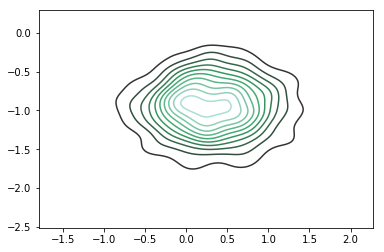

In [60]:
sns.kdeplot(samples[:,1,2,3], samples[:,1,2,1])
plt.show()

In [61]:
t = 18
params[t]

array([[ 0.26256903, -0.6518162 ,  0.74696963, -0.15384126],
       [-0.3732683 ,  0.49052328,  0.44550811, -0.37385512],
       [ 0.05862716, -1.18001719,  0.62563793,  0.5192165 ]])

In [62]:
np.mean(samples[:,t], axis=0)

array([[ 0.23084176, -0.5141754 ,  0.64686101, -0.20456169],
       [-0.44168648,  0.55376667,  0.33295568, -0.44601397],
       [-0.04107092, -0.95437647,  0.58843742,  0.27768149]])

In [51]:
params[0] - params[-1]

array([[-0.03363443,  0.01594778, -0.05966114, -0.03184394],
       [ 0.01225283, -0.06333269,  0.01810212,  0.05804125],
       [-0.0916567 ,  0.03942744, -0.0750497 , -0.04911167]])